### Import Packages

In [96]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# import the libraries for the models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# use nltk for stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
tokenizer = RegexpTokenizer(r'\b\w\w+\b')
nltk_stopwords = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eddie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Recreate labeled dataset from raw .txt data

In [98]:
# create book map dict containing the 7 books
# The data in the text is formatted in such a way that 0-7 refer to the respective books. 
# By using the labelled dataset I'm able to figure out which is which.

book_map = {
    '0': 'Buddhism',
    '1': 'TaoTeChing',
    '2': 'Upanishads',
    '3': 'YogaSutras',
    '4': 'Proverbs',
    '5': 'Ecclesiastes',
    '6': 'Ecclesiasticus',
    '7': 'Wisdom'
}

with open("Complete_data.txt", "r", encoding="latin1") as f:
    lines = [line.strip() for line in f.readlines()]

texts = []
labels = []

current_book_id = None
current_text = []

for line in lines:
    match = re.match(r'^(\d+)\.(\d+)$', line)
    if match:
        if current_book_id is not None and current_text:
            book_name = book_map.get(current_book_id)
            if book_name:
                texts.append(" ".join(current_text))
                labels.append(book_name)
        current_book_id = match.group(1)
        current_text = []
    else:
        if line:
            current_text.append(line)

if current_book_id is not None and current_text:
    book_name = book_map.get(current_book_id)
    if book_name:
        texts.append(" ".join(current_text))
        labels.append(book_name)

labeled_df_fixed = pd.DataFrame({'text': texts, 'label': labels})
labeled_df_fixed['label'] = labeled_df_fixed['label'].astype(str)

labeled_df_fixed

,text,label
0,"§ 1.The Buddha: ""What do you think, Rahula: Wh...",Buddhism
1,§ 2.Once the Blessed One was staying at Kosamb...,Buddhism
2,"§ 3.""'Stress should be known. The cause by whi...",Buddhism
3,"§ 4.""Vision arose, clear knowing arose, discer...",Buddhism
4,"§ 5.Sariputta: ""There are these three forms of...",Buddhism
...,...,...
585,condemning both the makers and the worshippers...,Wisdom
586,"worthily punished, and were destroyed by a mul...",Wisdom
587,"17:1. For thy judgments, O Lord, are great, an...",Wisdom
588,"intercession, in the sedition on occasion of C...",Wisdom


### Some Exploratory Data Analysis

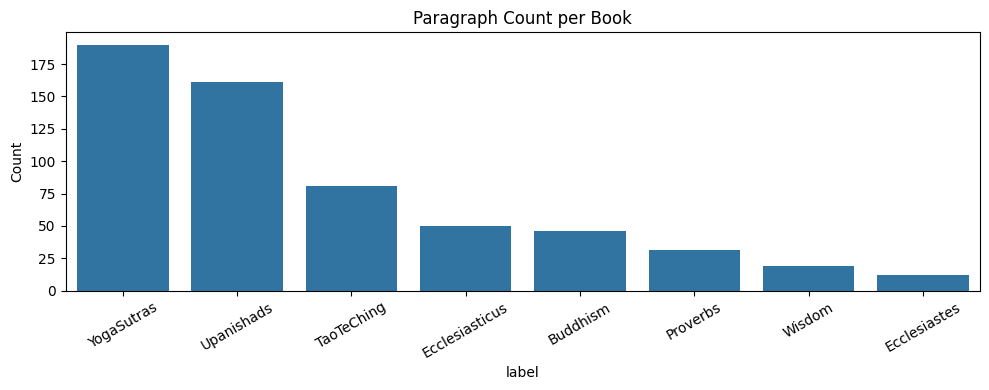

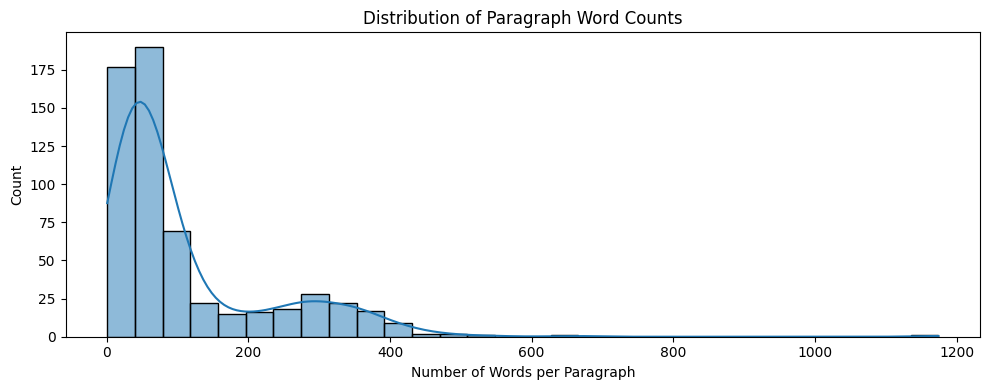

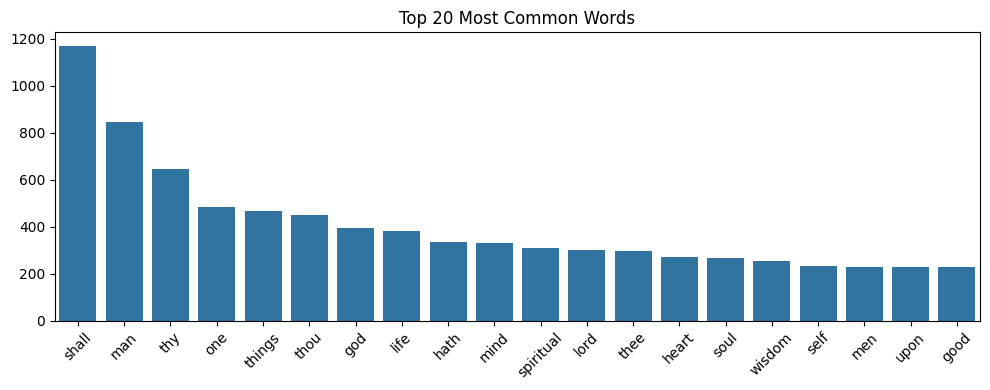

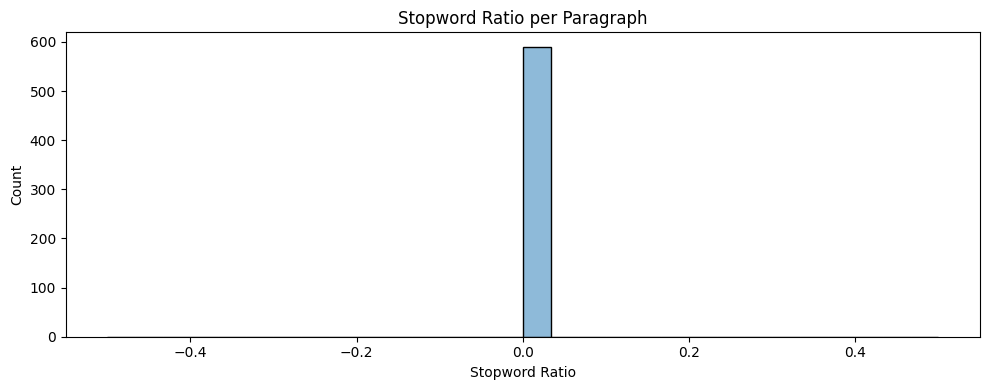

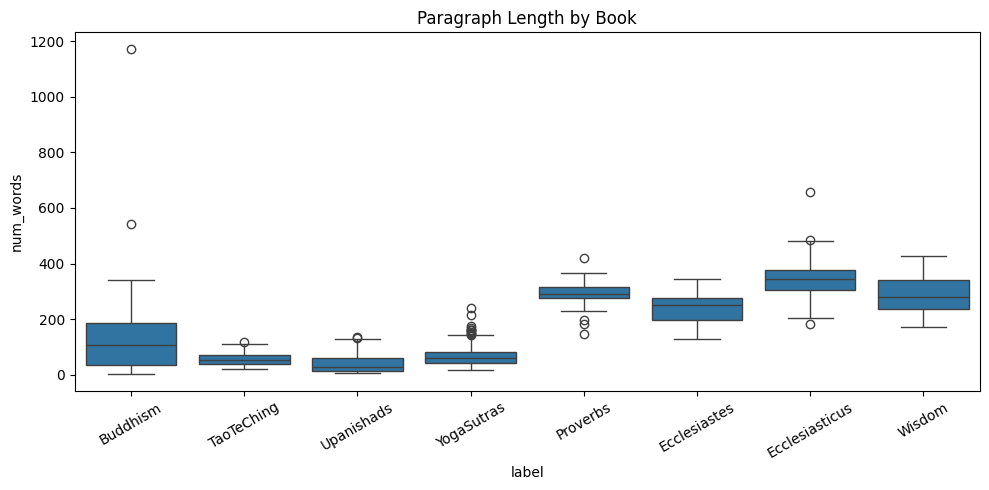

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Plot class dist
plt.figure(figsize=(10, 4))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.title("Paragraph Count per Book")
plt.xticks(rotation=30)
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('1.png')

plt.show()

# Plot Paragraph length
df['num_words'] = df['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 4))
sns.histplot(df['num_words'], bins=30, kde=True)
plt.title("Distribution of Paragraph Word Counts")
plt.xlabel("Number of Words per Paragraph")
plt.tight_layout()
plt.savefig('2.png')

plt.show()

# Most common words
all_words = " ".join(df['clean_text']).split()
common_words = Counter(all_words).most_common(20)

plt.figure(figsize=(10, 4))
sns.barplot(x=[w for w, c in common_words], y=[c for w, c in common_words])
plt.title("Top 20 Most Common Words")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('3.png')

plt.show()

# Stopword Ratio
df['stopword_ratio'] = df['clean_text'].apply(
    lambda x: sum(1 for w in x.split() if w in nltk_stopwords) / max(1, len(x.split()))
)

plt.figure(figsize=(10, 4))
sns.histplot(df['stopword_ratio'], bins=30, kde=True)
plt.title("Stopword Ratio per Paragraph")
plt.xlabel("Stopword Ratio")
plt.tight_layout()
plt.savefig('4.png')

plt.show()

# 5. Boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(x='label', y='num_words', data=df)
plt.title("Paragraph Length by Book")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('5.png')
plt.show()


### Clean Text and apply labels (convert to numbers for test-train-split)

In [99]:
df = labeled_df_fixed.copy()

def clean_text(text):
    tokens = tokenizer.tokenize(text.lower())
    return " ".join([t for t in tokens if t not in nltk_stopwords])

df['clean_text'] = df['text'].apply(clean_text)

encoder = LabelEncoder()
df['label_encoded'] = encoder.fit_transform(df['label'])


### Run Test-train split

In [100]:
X_train_text, X_test_text, y_train, y_test = train_test_split(df['clean_text'], df['label_encoded'],test_size=0.3, stratify=df['label_encoded'])

### Compare Text vectorization methods, each with 1000 maximum iterations

In [101]:
results = {}

# Bag of Words
vec = CountVectorizer()
X_train = vec.fit_transform(X_train_text)
X_test = vec.transform(X_test_text)
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
results["Bag of Words"] = accuracy_score(y_test, model.predict(X_test))

# TF-IDF
vec = TfidfVectorizer()
X_train = vec.fit_transform(X_train_text)
X_test = vec.transform(X_test_text)
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
results["TF-IDF"] = accuracy_score(y_test, model.predict(X_test))

# Hashing
vec = HashingVectorizer(n_features=1000)
X_train = vec.fit_transform(X_train_text)
X_test = vec.transform(X_test_text)
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
results["Hashing"] = accuracy_score(y_test, model.predict(X_test))


In [ ]:
import spacy
nlp = spacy.load("en_core_web_md")

def spacy_vector(text):
    return nlp(text).vector

X_train = np.array([spacy_vector(text) for text in X_train_text])
X_test = np.array([spacy_vector(text) for text in X_test_text])

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
results["spaCy"] = accuracy_score(y_test, model.predict(X_test))


### Add Word2Vec

In [ ]:
word_list = [word for text in df['clean_text'] for word in text.split()]
corpus = [word_list]

w2v_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4, epochs=10)

def avg_vec(tokens, model, dim=100):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(dim)

X_train = np.array([avg_vec(t.split(), w2v_model) for t in X_train_text])
X_test = np.array([avg_vec(t.split(), w2v_model) for t in X_test_text])

model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
results["Word2Vec"] = accuracy_score(y_test, model.predict(X_test))


### Plot Results

Bag of Words: 0.8305
TF-IDF: 0.7401
Hashing: 0.7401
spaCy: 0.7006
Word2Vec: 0.3051


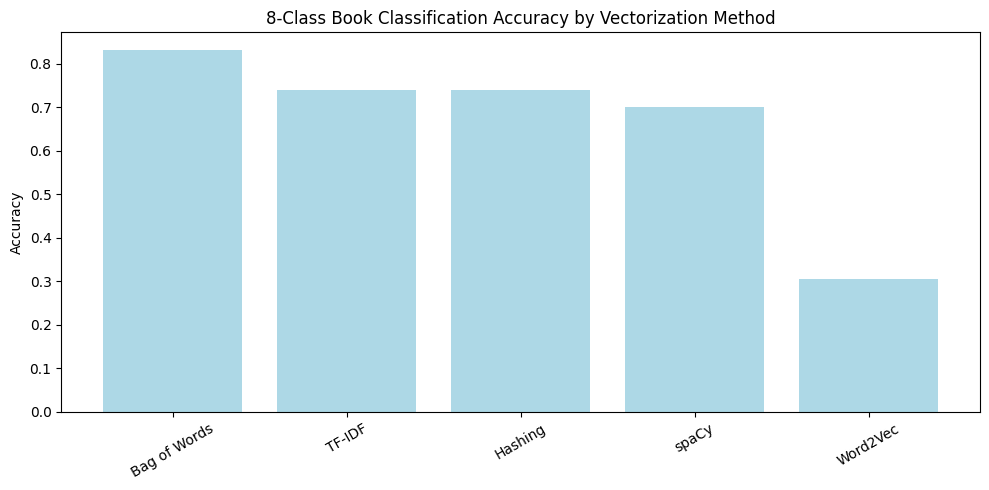

In [94]:
for method, acc in results.items():
    print(f"{method}: {acc:.4f}")

plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), color='lightblue')
plt.ylabel("Accuracy")
plt.title("8-Class Book Classification Accuracy by Vectorization Method")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


### Apply Each Classifier and Generate Accuracy Matrix

In [104]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import seaborn as sns

# Create the classifiers used
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}


vectorizers = {
    "Bag of Words": CountVectorizer(),
    "TF-IDF": TfidfVectorizer(),
    "Hashing": HashingVectorizer(n_features=1000),
    "Word2Vec": "word2vec",
    "spaCy": "spacy"
}

# Create word2vec model and spaCy model
corpus = [text.split() for text in df['clean_text']]
w2v_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4, epochs=10)

def avg_vec(tokens, model, dim=100):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(dim)

def spacy_vector(text):
    return nlp(text).vector

# Store accuracy in pd.df
accuracy_matrix = pd.DataFrame(index=vectorizers.keys(), columns=classifiers.keys())

for vec_name, vec in vectorizers.items():
    print(f"Processing vectorizer: {vec_name}")

    if vec_name == "Word2Vec":
        X_train = np.array([avg_vec(t.split(), w2v_model) for t in X_train_text])
        X_test = np.array([avg_vec(t.split(), w2v_model) for t in X_test_text])
    elif vec_name == "spaCy":
        X_train = np.array([spacy_vector(t) for t in X_train_text])
        X_test = np.array([spacy_vector(t) for t in X_test_text])
    else:
        X_train = vec.fit_transform(X_train_text)
        X_test = vec.transform(X_test_text)

    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracy_matrix.loc[vec_name, clf_name] = round(acc, 4)

# Print out accuracies
print("\nAccuracy Matrix (5 vectorizers × 4 classifiers):")
print(accuracy_matrix)


Processing vectorizer: Bag of Words
Processing vectorizer: TF-IDF
Processing vectorizer: Hashing
Processing vectorizer: Word2Vec
Processing vectorizer: spaCy

Accuracy Matrix (5 vectorizers × 4 classifiers):
             LogisticRegression     SVM RandomForest     MLP
Bag of Words             0.8588  0.8983       0.8362   0.887
TF-IDF                   0.7627  0.9266       0.8249  0.9322
Hashing                  0.7345  0.8475       0.8079  0.8588
Word2Vec                 0.4802  0.5989        0.661  0.4972
spaCy                    0.7684  0.8475       0.7401  0.8644


c:\Users\eddie\Documents\Classes\Gateway Data Science\ds-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


### Plot Accuracy Matrix

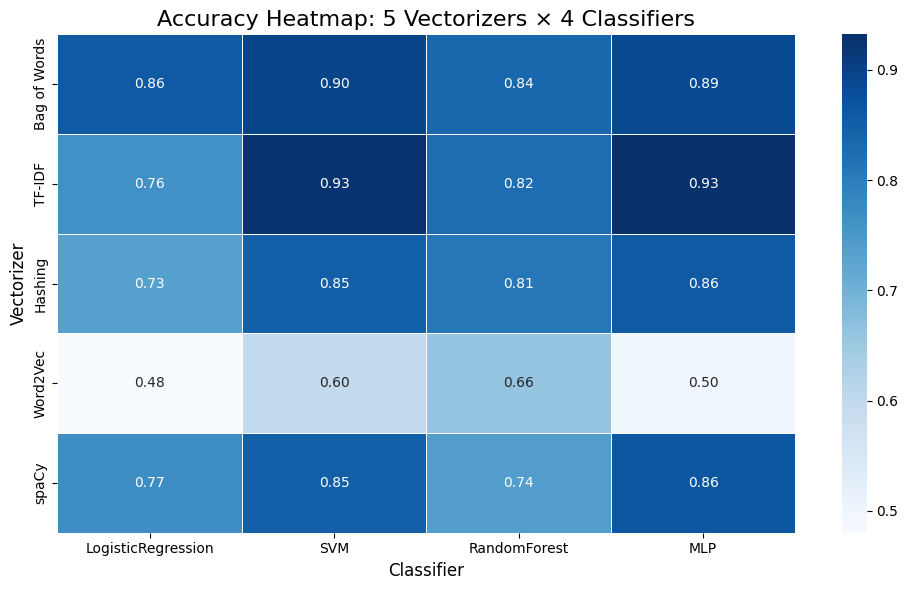

In [105]:
plt.figure(figsize=(10, 6))
sns.heatmap(accuracy_matrix.astype(float), annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Accuracy Heatmap: 5 Vectorizers × 4 Classifiers", fontsize=16)
plt.ylabel("Vectorizer", fontdict={'fontsize': 12})
plt.xlabel("Classifier", fontdict={'fontsize': 12})
plt.tight_layout()
plt.show()

### Generate Confusion Matrices

In [106]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Loop again and generate + save confusion matrices
for vec_name, vec in vectorizers.items():
    print(f"Processing confusion matrices for vectorizer: {vec_name}")

    if vec_name == "Word2Vec":
        X_train = np.array([avg_vec(t.split(), w2v_model) for t in X_train_text])
        X_test = np.array([avg_vec(t.split(), w2v_model) for t in X_test_text])
    elif vec_name == "spaCy":
        X_train = np.array([spacy_vector(t) for t in X_train_text])
        X_test = np.array([spacy_vector(t) for t in X_test_text])
    else:
        X_train = vec.fit_transform(X_train_text)
        X_test = vec.transform(X_test_text)

    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot and save
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=encoder.classes_, yticklabels=encoder.classes_)
        plt.title(f"Confusion Matrix\n{vec_name} + {clf_name}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        
        # Save to Figures folder
        fname = f"Figures/confmat_{vec_name.replace(' ', '')}_{clf_name}.png"
        plt.savefig(fname)
        plt.close()


Processing confusion matrices for vectorizer: Bag of Words
Processing confusion matrices for vectorizer: TF-IDF
Processing confusion matrices for vectorizer: Hashing
Processing confusion matrices for vectorizer: Word2Vec
Processing confusion matrices for vectorizer: spaCy


c:\Users\eddie\Documents\Classes\Gateway Data Science\ds-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


### Plot Confusion Matrices

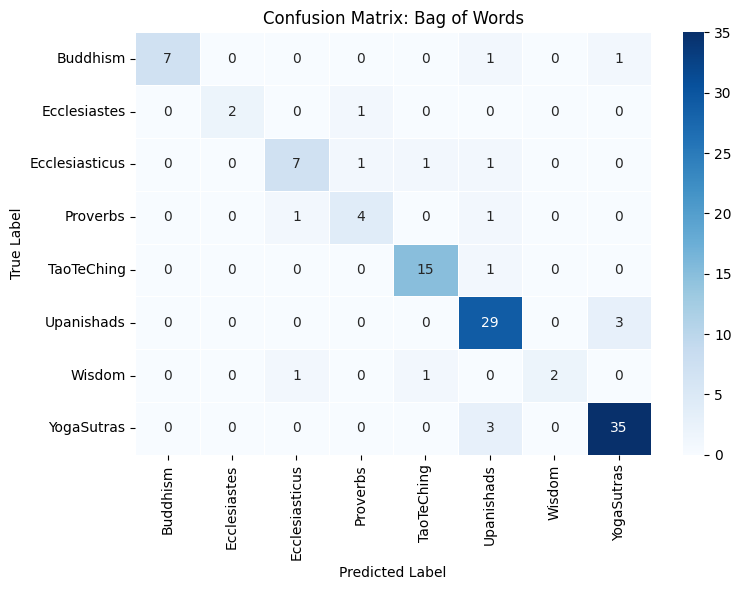

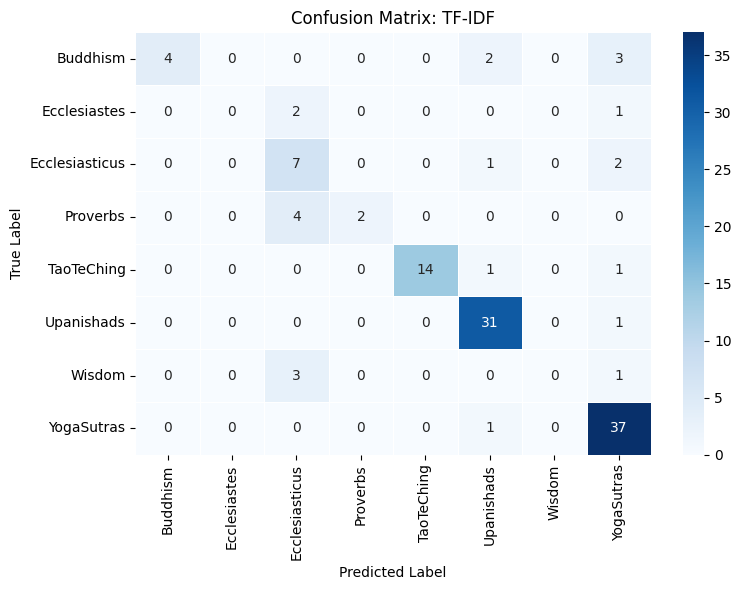

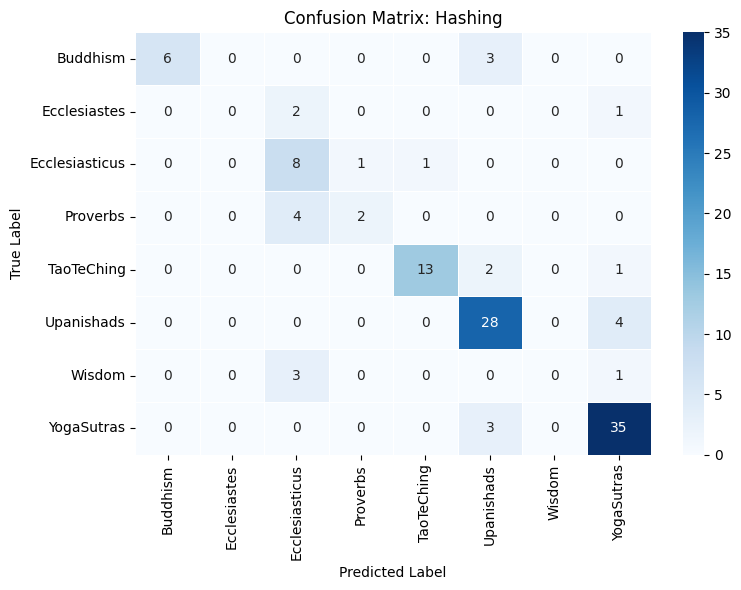

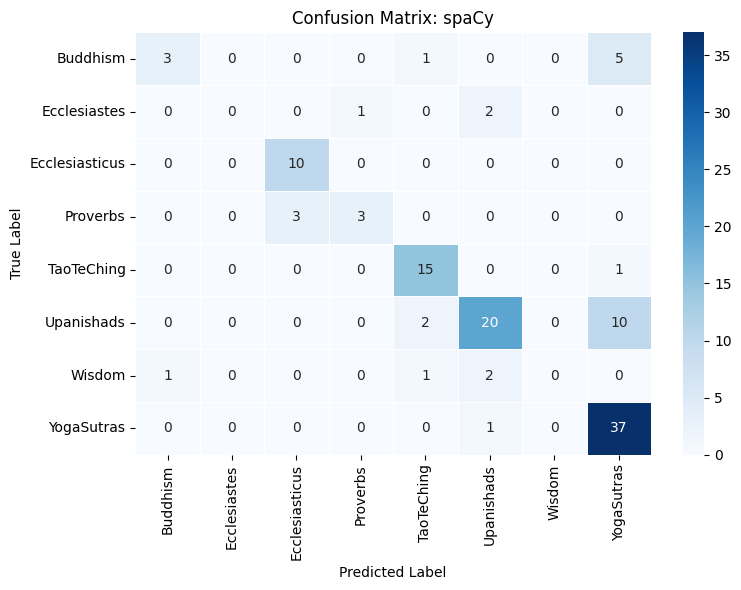

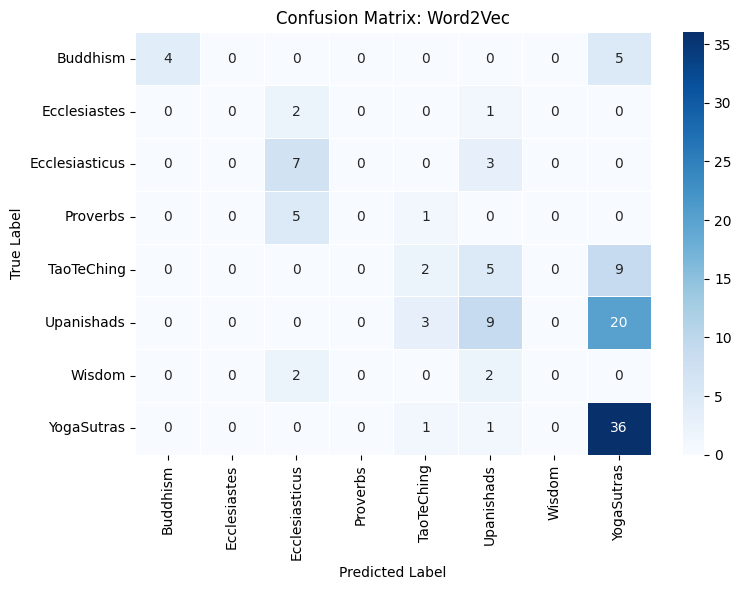

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_conf_matrix(matrix, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, linewidths=0.5)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

class_names = encoder.classes_

# plot for each method
for method in validation_results:
    cm = validation_results[method]['confusion_matrix']
    plot_conf_matrix(cm, class_names, title=f"Confusion Matrix: {method}")


### Apply PCA for further Validation and Analysis

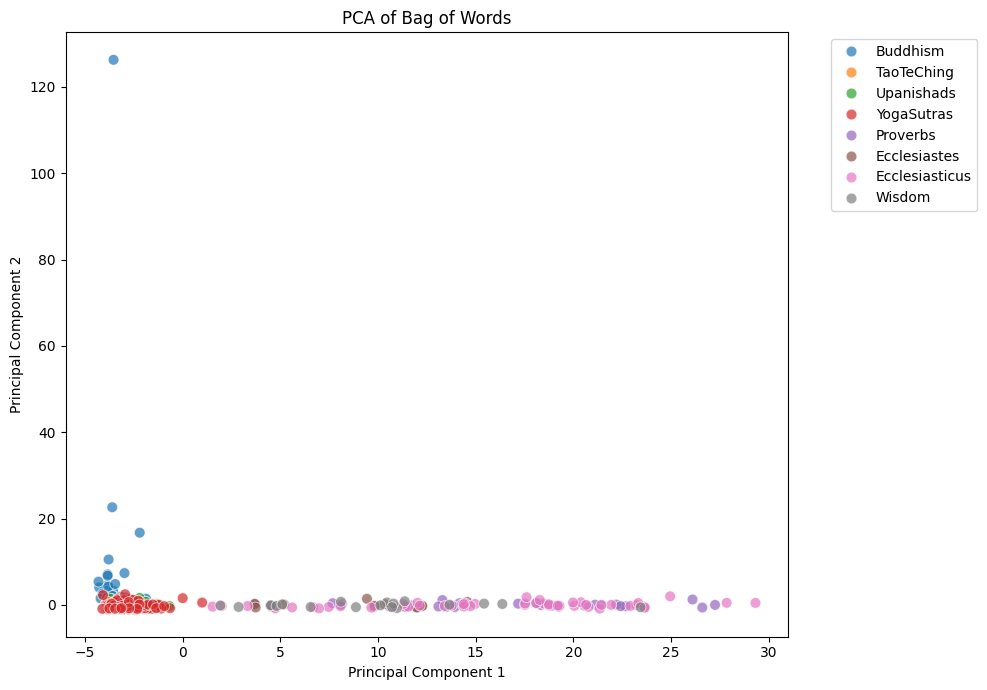

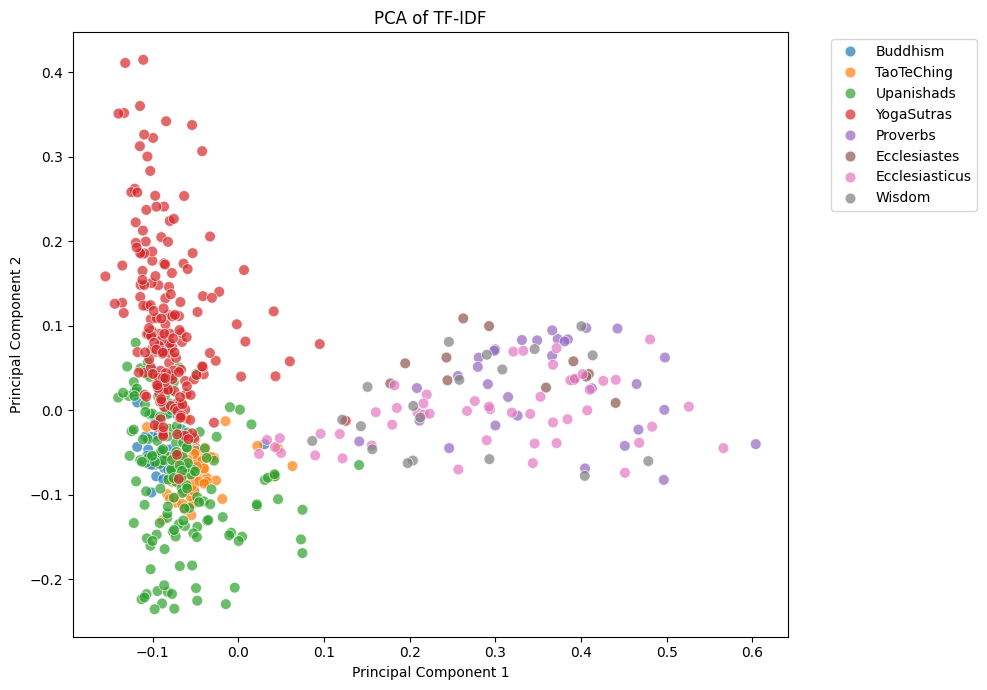

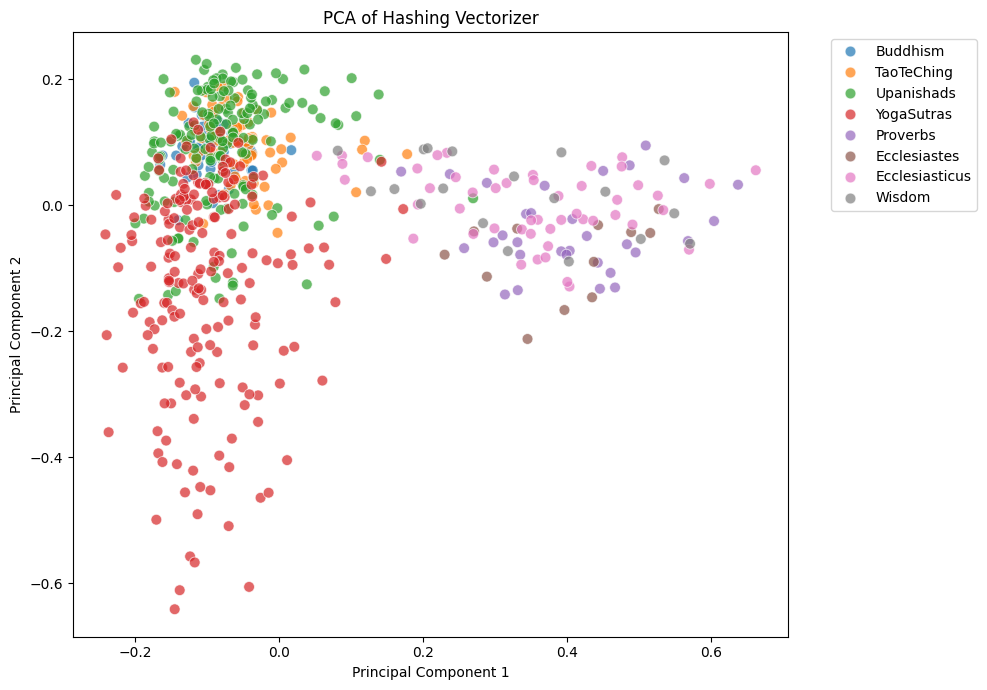

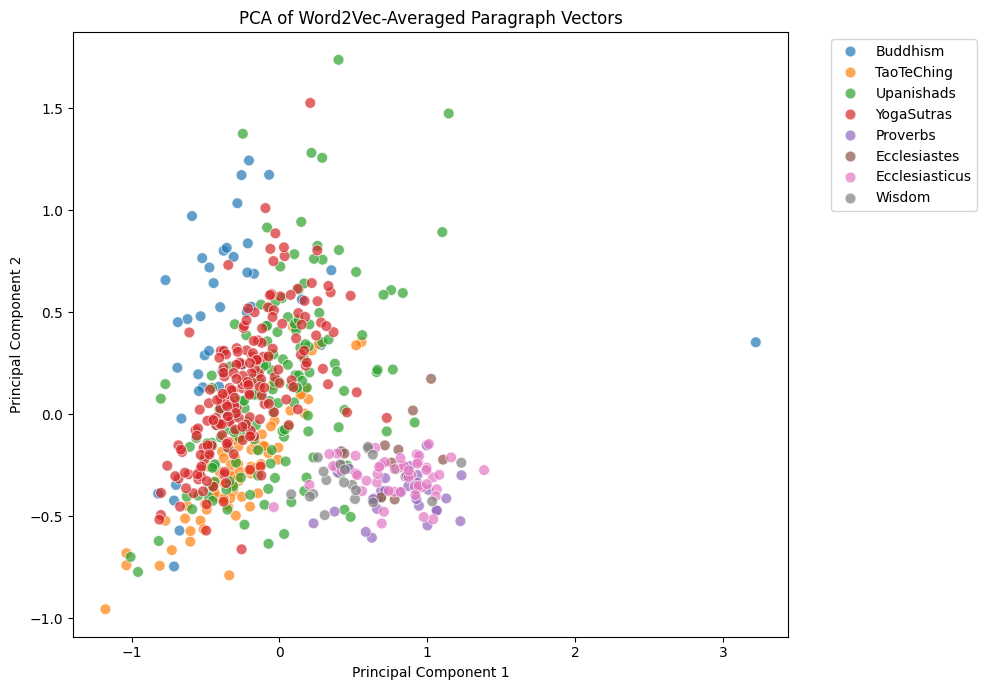

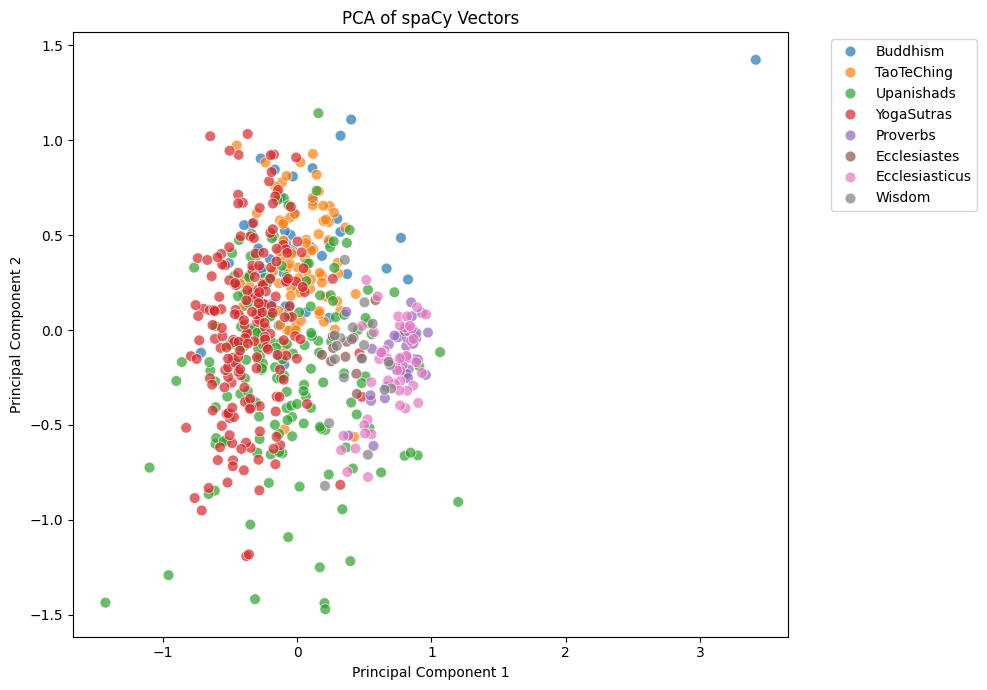

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pca(X, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(X)
    df_plot = pd.DataFrame({
        'PC1': reduced[:, 0],
        'PC2': reduced[:, 1],
        'Label': df['label']
    })
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Label', palette='tab10', alpha=0.7, s=60)
    plt.title(f"PCA of {title}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Bag of Words
vec = CountVectorizer()
X_bow = vec.fit_transform(df['clean_text']).toarray()
plot_pca(X_bow, "Bag of Words")

# TF-IDF
vec = TfidfVectorizer()
X_tfidf = vec.fit_transform(df['clean_text']).toarray()
plot_pca(X_tfidf, "TF-IDF")

# Hashing
vec = HashingVectorizer(n_features=1000)
X_hash = vec.fit_transform(df['clean_text']).toarray()
plot_pca(X_hash, "Hashing Vectorizer")

# Word2Vec
X_w2v = np.array([avg_vec(t.split(), w2v_model) for t in df['clean_text']])
plot_pca(X_w2v, "Word2Vec-Averaged Paragraph Vectors")

# spaCy
X_spacy = np.array([spacy_vector(t) for t in df['clean_text']])
plot_pca(X_spacy, "spaCy Vectors")


### Check for Overfitting

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Vectorizers
vectorizers = {
    "Bag of Words": CountVectorizer(),
    "TF-IDF": TfidfVectorizer(),
    "Hashing": HashingVectorizer(n_features=1000),
    "Word2Vec": "word2vec",
    "spaCy": "spacy"
}

print("\nOverfitting Check (Train vs Test Accuracy):\n")

for vec_name, vec in vectorizers.items():
    if vec_name == "Word2Vec":
        X = np.array([avg_vec(t.split(), w2v_model) for t in df['clean_text']])
    elif vec_name == "spaCy":
        X = np.array([spacy_vector(t) for t in df['clean_text']])
    else:
        X = vec.fit_transform(df['clean_text'])

    y = df['label_encoded']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    for clf_name, clf in classifiers.items():
        model = clf
        model.fit(X_train, y_train)

        train_acc = accuracy_score(y_train, model.predict(X_train))
        test_acc = accuracy_score(y_test, model.predict(X_test))

        gap = train_acc - test_acc
        print(f"{vec_name:<12} | {clf_name:<20} | Train: {train_acc:.3f} | Test: {test_acc:.3f} | Gap: {gap:.3f}")



Overfitting Check (Train vs Test Accuracy):

Bag of Words | LogisticRegression   | Train: 0.998 | Test: 0.802 | Gap: 0.195
Bag of Words | SVM                  | Train: 1.000 | Test: 0.819 | Gap: 0.181
Bag of Words | RandomForest         | Train: 1.000 | Test: 0.802 | Gap: 0.198
Bag of Words | MLP                  | Train: 1.000 | Test: 0.831 | Gap: 0.169
TF-IDF       | LogisticRegression   | Train: 0.942 | Test: 0.785 | Gap: 0.157
TF-IDF       | SVM                  | Train: 1.000 | Test: 0.893 | Gap: 0.107
TF-IDF       | RandomForest         | Train: 1.000 | Test: 0.819 | Gap: 0.181
TF-IDF       | MLP                  | Train: 1.000 | Test: 0.904 | Gap: 0.096
Hashing      | LogisticRegression   | Train: 0.923 | Test: 0.763 | Gap: 0.160
Hashing      | SVM                  | Train: 1.000 | Test: 0.831 | Gap: 0.169
Hashing      | RandomForest         | Train: 1.000 | Test: 0.791 | Gap: 0.209
Hashing      | MLP                  | Train: 1.000 | Test: 0.853 | Gap: 0.147
Word2Vec     | Log

c:\Users\eddie\Documents\Classes\Gateway Data Science\ds-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
